In [1]:
suppressWarnings(library(BayesPrism))
library(tidyverse)

Loading required package: snowfall

Loading required package: snow

Loading required package: NMF

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks Bioc

In [2]:
SC.eset <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution/CTCL1-8_skin_atlas_integration_portal_rawcounts_sub0.08_notu_ExpressionSet.rds')
SC.eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 33538 features, 54028 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: CACACAAGTTAGAACA-1-SKN8090605-Psoriasis
    CGTGAGCCACCTTGTC-15-CTCL ... ACTGAACGTCGCGAAA-17-CTCL (54028 total)
  varLabels: donor_id sample_id ... anno (5 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

In [3]:
sc.dat <- as.matrix(exprs(SC.eset)) %>% t()
dim(sc.dat)

[1] 54028 33538

In [6]:
Bulk.eset <- readRDS('/home/jovyan/farm/CTCL/deconvolution/CTCL-PKU_ExpressionSet.rds') ## CTCL
#Bulk.eset <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution/GSE121212_readcount_ExpressionSet.rds') ## healthy skin, AD and psoriasis

Bulk.eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 33216 features, 49 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: B266 B355 ... N69 (49 total)
  varLabels: condition
  varMetadata: labelDescription
featureData
  featureNames: METTL25 LINC01742 ... INVS (33216 total)
  fvarLabels: gene_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [7]:
bk.dat <- t(as.matrix(exprs(Bulk.eset)))
dim(bk.dat)

[1]    49 33216

In [9]:
cell.type.labels <- as.vector(phenoData(SC.eset)$anno)
cell.state.labels <- as.vector(phenoData(SC.eset)$anno)


### Filter outlier genes

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


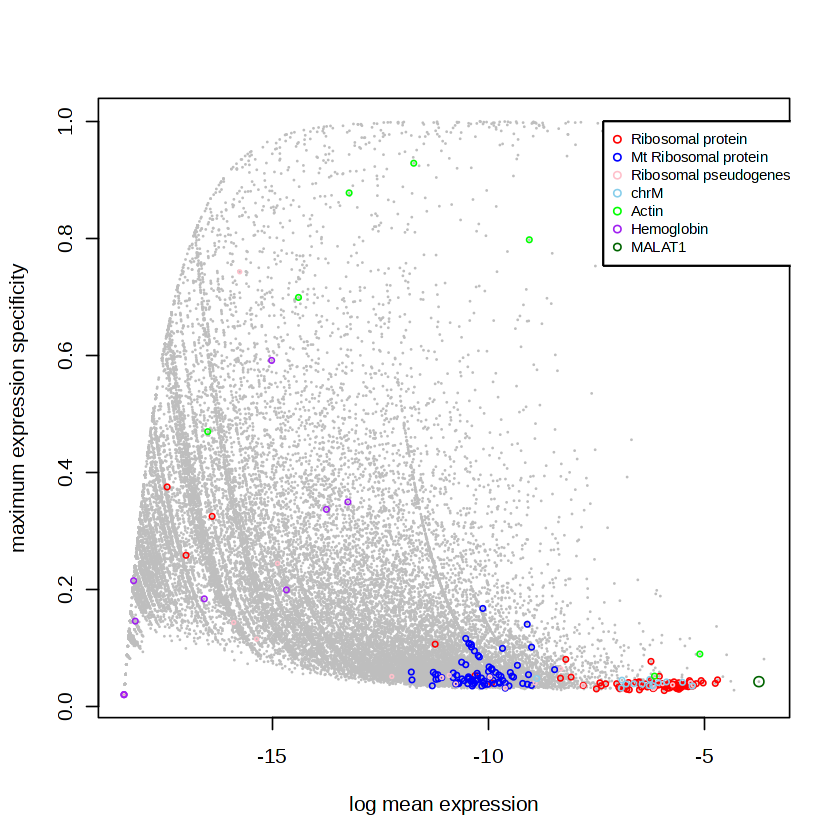

In [10]:
sc.stat <- plot.scRNA.outlier(
  input=sc.dat, #make sure the colnames are gene symbol or ENSMEBL ID 
  cell.type.labels=cell.type.labels,
  species="hs", #currently only human(hs) and mouse(mm) annotations are supported
  return.raw=TRUE #return the data used for plotting. 
  #pdf.prefix="gbm.sc.stat" specify pdf.prefix if need to output to pdf
)
#> EMSEMBLE IDs detected.


In [11]:
head(sc.stat)  

,exp.mean.log,max.spec,other_Rb,chrM,chrX,chrY,Rb,Mrp,act,hb,MALAT1
,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
MIR1302-2HG,-18.42068,0.02040816,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FAM138A,-18.42068,0.02040816,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
OR4F5,-18.42068,0.02040816,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AL627309.1,-15.39562,0.21883081,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AL627309.3,-18.40238,0.03817066,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AL627309.2,-18.42068,0.02040816,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


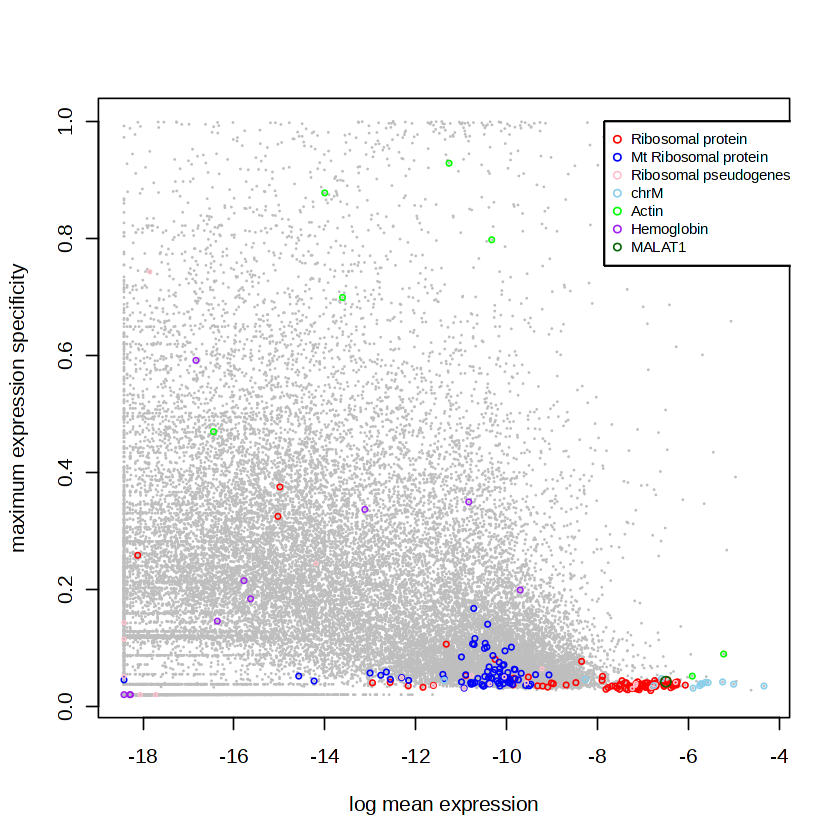

In [12]:
bk.stat <- plot.bulk.outlier(
  bulk.input=bk.dat,#make sure the colnames are gene symbol or ENSMEBL ID 
    sc.input=sc.dat, #make sure the colnames are gene symbol or ENSMEBL ID 
  cell.type.labels=cell.type.labels,
  species="hs", #currently only human(hs) and mouse(mm) annotations are supported
  return.raw=TRUE
  #pdf.prefix="gbm.bk.stat" specify pdf.prefix if need to output to pdf
)
#> EMSEMBLE IDs detected.

In [13]:
head(bk.stat)

,exp.mean.log,max.spec,other_Rb,chrM,chrX,chrY,Rb,Mrp,act,hb,MALAT1
,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
METTL25,-12.06643,0.05133988,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
LINC01742,-18.34815,0.02040816,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
CXorf51A,-18.42068,0.02040816,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AC093525.4,-15.21725,0.14141368,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
C3orf79,-15.93276,0.96600779,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
THOC3,-10.62218,0.09692061,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [14]:
sc.dat.filtered <- cleanup.genes (input=sc.dat,
                                  input.type="count.matrix",
                                    species="hs", 
                                    gene.group=c( "Rb","Mrp","other_Rb","chrM","MALAT1","chrX","chrY") ,
                                    exp.cells=5)

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes filtered in each category: 
      Rb      Mrp other_Rb     chrM   MALAT1     chrX     chrY 
      89       78       21       13        1     1055      124 
A total of  1340  genes from Rb Mrp other_Rb chrM MALAT1 chrX chrY  have been excluded 
A total of  9807  gene expressed in fewer than  5  cells have been excluded 


In [15]:
dim(sc.dat.filtered)

[1] 54028 22391

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.


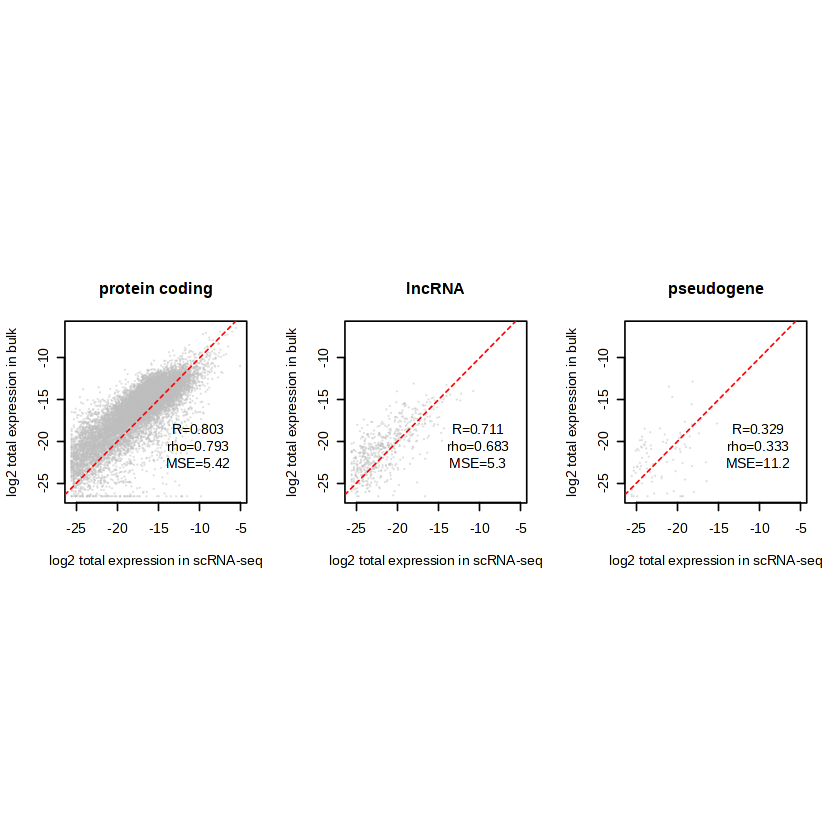

In [16]:
#note this function only works for human data. For other species, you are advised to make plots by yourself.
plot.bulk.vs.sc (sc.input = sc.dat.filtered,
                            bulk.input = bk.dat
                            #pdf.prefix="gbm.bk.vs.sc" specify pdf.prefix if need to output to pdf
)

In [17]:
sc.dat.filtered.pc <-  select.gene.type (sc.dat.filtered,
                                        gene.type = "protein_coding")

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes retained in each category: 

protein_coding 
         15615 


In [ ]:

# Select marker genes (Optional)
# performing pair-wise t test for cell states from different cell types

diff.exp.stat <- get.exp.stat(sc.dat=sc.dat[,colSums(sc.dat>0)>3],# filter genes to reduce memory use
                                          cell.type.labels=cell.type.labels,
                                          cell.state.labels=cell.state.labels,
                                          psuedo.count=0.1, #a numeric value used for log2 transformation. =0.1 for 10x data, =10 for smart-seq. Default=0.1.
                                          cell.count.cutoff=50, # a numeric value to exclude cell state with number of cells fewer than this value for t test. Default=50.
                                          n.cores=5 #number of threads
                                          )

In [18]:
sc.dat.filtered.pc.sig <- select.marker (sc.dat=sc.dat.filtered.pc,
                                                  stat=diff.exp.stat,
                                                  pval.max=0.01,
                                                  lfc.min=0.1)

number of markers selected for each cell type: 
VE2 :  138 
CD8_RM :  2 
Th :  0 
Th2 :  8 
Schwann :  39 
pDC :  19 
Proliferating_KC :  359 
Differentiated_KC :  191 
VE1 :  64 
CD8_cytox :  3 
Undifferentiated_KC :  40 
Pericyte_1 :  48 
CD4_eff :  16 
B/plasma :  136 
LC2 :  28 
LC3 :  2 
MoDC2 :  44 
MoDC1 :  3 
F3 :  43 
LC4 :  126 
MonoMac :  67 
CD4_CM-like :  13 
F2 :  131 
Melanocyte :  423 
F1 :  323 
Mac1 :  40 
MoDC3 :  94 
Differentiated_KC* :  376 
ILC1/NK :  18 
Treg :  50 
NK/CD8 :  20 
Inf_Mac :  8 
Mast :  36 
Mac2 :  36 
LE2 :  155 
VE3 :  99 
CD8_CM-like :  5 
ILC1/3 :  31 
DC2 :  12 
DC1 :  30 
Mig_DC2 :  65 
Th1 :  25 
Proliferating_T-cell :  16 
Mig_DC1 :  56 
Pericyte_2 :  153 
LE1 :  25 
LC1 :  30 
Proliferating_APC :  7 
Th22 :  147 


In [19]:
dim(sc.dat.filtered.pc.sig)

[1] 54028  3247

#### Construct a prism object

In [17]:
myPrism <- new.prism(
  reference=sc.dat.filtered.pc, ### or sc.dat.filtered.pc.sig
  mixture=bk.dat,
  input.type="count.matrix", 
  cell.type.labels = cell.type.labels, 
  cell.state.labels = cell.state.labels,
  key=NULL,
  outlier.cut=0.01,
    outlier.fraction=0.1,
)

number of cells in each cell state 
cell.state.labels
                Th22    Proliferating_APC                  pDC 
                   2                   86                   93 
             Mig_DC2              Schwann               NK/CD8 
                  96                  110                  145 
                 Th1 Proliferating_T-cell              Mig_DC1 
                 148                  154                  209 
                 LC1                 Mast           Pericyte_2 
                 224                  293                  300 
             Inf_Mac          CD8_CM-like                  LE1 
                 315                  321                  334 
    Proliferating_KC                 Mac2                  VE3 
                 342                  394                  409 
                 DC1              ILC1/NK                  LE2 
                 411                  429                  430 
            B/plasma                  LC2         

In [18]:
bp.res <- run.prism(prism = myPrism, n.cores=50)

Run Gibbs sampling... 
Current time:  2023-07-25 15:43:52 
Estimated time to complete:  8mins 
Estimated finishing time:  2023-07-25 15:51:25 
Start run... 
R Version:  R version 4.0.4 (2021-02-15) 



snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 50 CPUs.



Stopping cluster




Update the reference matrix ... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 50 CPUs.



Stopping cluster




Run Gibbs sampling using updated reference ... 
Current time:  2023-07-25 16:11:15 
Estimated time to complete:  7mins 
Estimated finishing time:  2023-07-25 16:18:05 
Start run... 


snowfall 1.84-6.2 initialized (using snow 0.4-4): parallel execution on 50 CPUs.



Stopping cluster




In [19]:
#bp.res

In [20]:
slotNames(bp.res)

[1] "prism"                       "posterior.initial.cellState"
[3] "posterior.initial.cellType"  "reference.update"           
[5] "posterior.theta_f"           "control_param"

In [21]:
# extract posterior mean of cell type fraction theta
theta <- get.fraction(bp=bp.res,
            which.theta="final",
            state.or.type="type")

head(theta)

,VE2,CD8_RM,Th,Th2,Schwann,pDC,Proliferating_KC,Differentiated_KC,VE1,CD8_cytox,⋯,DC1,Mig_DC2,Th1,Proliferating_T-cell,Mig_DC1,Pericyte_2,LE1,LC1,Proliferating_APC,Th22
B266,7.495667e-05,3.795429e-04,7.040845e-02,8.527970e-04,6.356388e-04,8.690313e-04,2.115314e-01,1.553880e-01,6.197209e-06,1.151721e-02,⋯,1.234688e-03,9.446909e-07,0.0728329408,1.207661e-06,1.677466e-04,0.010864688,1.293812e-06,7.707839e-03,9.016481e-07,1.613362e-05
B355,1.324267e-02,6.780238e-03,1.443275e-01,6.321220e-06,9.035327e-07,9.132346e-03,2.596911e-02,7.058928e-02,1.685103e-06,1.446045e-05,⋯,6.224320e-03,2.358990e-03,0.1253419494,9.955809e-02,2.268270e-04,0.009587109,2.086173e-03,1.811694e-02,4.323780e-06,1.873219e-06
B470,6.704848e-07,8.731335e-06,4.935473e-02,2.768170e-06,7.413179e-02,3.095469e-04,4.634960e-07,7.544714e-02,3.505913e-06,6.240499e-04,⋯,5.705704e-06,1.044978e-06,0.1103910346,4.467150e-06,3.225433e-02,0.041445445,5.324544e-03,3.465074e-02,4.572826e-06,1.420693e-06
B520-2,1.976084e-05,1.501590e-06,9.179799e-06,9.168405e-07,5.022063e-07,6.118914e-05,1.917152e-06,4.333442e-02,1.232342e-02,6.524205e-07,⋯,6.392436e-07,3.572457e-03,0.0317960745,1.095784e-01,9.949674e-07,0.007482635,1.353601e-03,3.836178e-03,1.396194e-06,1.235394e-06
L107,9.114609e-06,7.937344e-06,8.932840e-07,4.966093e-06,6.939619e-07,1.245555e-06,1.426073e-02,2.312997e-02,1.922060e-03,4.686837e-03,⋯,2.209772e-02,5.873824e-07,0.0006040461,2.205725e-01,7.095361e-07,0.001680161,3.405171e-06,1.356462e-06,1.489490e-03,3.511188e-06
L112,6.520290e-02,1.044851e-06,7.083343e-05,9.426536e-07,4.805445e-07,3.495268e-04,5.556275e-07,8.148949e-05,8.961266e-07,1.228229e-06,⋯,1.349582e-06,1.031940e-06,0.0057051057,1.171190e-01,2.795611e-06,0.007265974,1.341070e-04,1.879698e-03,1.085782e-06,1.784987e-06


In [22]:
saveRDS(bp.res, '/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution/Deconv_PKU_CTCL_integrated_atlas_sub0.08_allgenes.rds')


In [31]:
library(tidyverse)
library(ggbeeswarm)
library(ggplot2)
library(reshape2)
library(SingleCellExperiment)

In [32]:
E_1 <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution/Deconv_GSE121212_integrated_atlas_sub0.08_DEGs.rds')
E_2 <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution/Deconv_PKU_CTCL_integrated_atlas_sub0.08_DEGs.rds')

In [33]:
Est_1 <- get.fraction(bp=E_1,
            which.theta="final",
            state.or.type="type")

head(Est_1)

,VE2,CD8_RM,Th,Th2,Schwann,pDC,Proliferating_KC,Differentiated_KC,VE1,CD8_cytox,⋯,DC1,Mig_DC2,Th1,Proliferating_T-cell,Mig_DC1,Pericyte_2,LE1,LC1,Proliferating_APC,Th22
AD_004_lesional,0.012739836,1.328255e-05,1.326139e-05,2.387931e-02,5.962696e-06,5.889050e-06,7.779023e-02,0.4951669,4.135274e-05,1.728775e-05,⋯,5.216567e-06,1.571823e-05,1.191801e-02,7.958592e-06,8.300922e-06,0.008895895,2.247415e-05,0.0042356823,2.350435e-05,3.000362e-05
AD_004_non-lesional,0.004736655,1.215327e-05,7.806645e-02,1.021045e-05,1.620417e-05,2.058300e-06,2.460675e-06,0.4847388,1.027613e-05,7.280292e-06,⋯,2.959614e-06,5.231060e-06,6.746769e-06,5.090719e-06,3.306308e-05,0.005795738,1.020447e-05,0.0036055837,4.652005e-06,1.063675e-05
AD_005_lesional,0.019330310,7.000567e-06,3.133163e-06,3.325148e-02,2.096690e-05,6.915415e-06,1.881019e-05,0.3939821,4.326604e-03,1.271244e-03,⋯,7.922766e-06,1.513195e-02,4.617700e-03,3.517716e-06,8.991394e-06,0.016002410,8.198655e-04,0.0005518619,4.207242e-06,1.058477e-05
AD_005_non-lesional,0.016843206,7.584636e-06,4.500185e-02,5.827041e-06,2.158143e-03,2.605282e-06,1.387756e-06,0.4176165,8.549719e-06,4.055333e-06,⋯,2.704615e-06,1.895527e-06,1.843986e-06,2.006423e-06,1.220614e-05,0.017259783,2.032463e-05,0.0018744778,2.489229e-06,5.395277e-06
AD_006_lesional,0.013499594,9.117776e-04,6.206683e-05,5.728856e-03,8.304841e-06,9.007902e-06,1.521621e-02,0.6174518,1.626793e-05,3.127385e-05,⋯,5.510325e-06,6.272840e-06,3.973550e-05,6.332618e-03,9.296099e-06,0.006942767,6.774464e-04,0.0030287956,2.991175e-05,3.985523e-03
AD_006_non-lesional,0.011145534,2.383410e-05,4.775945e-02,1.126932e-02,2.134683e-05,7.810080e-06,4.041304e-06,0.4442301,1.361709e-05,9.042377e-06,⋯,2.236697e-05,8.420927e-06,5.783783e-06,6.446923e-06,3.679385e-05,0.006151943,3.712658e-06,0.0062167740,1.311828e-05,1.937733e-03


In [34]:
Est_2 <- get.fraction(bp=E_2,
            which.theta="final",
            state.or.type="type")

head(Est_2)

,VE2,CD8_RM,Th,Th2,Schwann,pDC,Proliferating_KC,Differentiated_KC,VE1,CD8_cytox,⋯,DC1,Mig_DC2,Th1,Proliferating_T-cell,Mig_DC1,Pericyte_2,LE1,LC1,Proliferating_APC,Th22
B266,1.627714e-05,1.686011e-05,8.376666e-03,5.711101e-05,5.361606e-04,4.296810e-06,1.662743e-01,0.270430586,2.099872e-06,3.339440e-06,⋯,1.024352e-05,2.248479e-06,3.552813e-02,1.616618e-06,3.359938e-03,0.012026855,2.461549e-06,1.564994e-03,2.270797e-06,8.472277e-05
B355,1.809743e-02,5.862085e-04,8.894421e-02,1.871242e-05,1.127401e-06,5.406240e-03,2.078931e-02,0.127407214,2.083207e-05,3.232950e-06,⋯,5.178321e-03,1.868932e-05,9.608894e-02,2.565353e-02,1.766125e-05,0.011221406,8.563668e-04,6.027319e-03,7.966908e-06,7.004856e-05
B470,3.473765e-06,6.077225e-06,1.803912e-02,5.197089e-06,6.365008e-02,3.206657e-06,9.900565e-07,0.127112242,2.973083e-06,1.479607e-05,⋯,4.905292e-03,2.725101e-06,6.555960e-02,1.443632e-06,1.561481e-02,0.051004244,1.051776e-05,1.210854e-02,2.830648e-06,7.269149e-05
B520-2,6.667150e-06,1.579582e-04,1.346550e-04,2.042309e-05,1.183931e-06,8.706348e-03,2.390148e-06,0.074511964,5.775821e-02,3.750401e-06,⋯,1.091012e-06,6.770649e-04,4.005916e-03,4.844923e-02,1.560083e-06,0.006578095,6.440928e-06,4.380996e-06,3.077717e-06,5.753656e-05
L107,6.733161e-06,3.630577e-06,2.433023e-06,2.096155e-06,1.189153e-06,3.708193e-06,8.151027e-03,0.045585601,2.304365e-06,2.611179e-06,⋯,1.883230e-05,1.784041e-06,2.862297e-06,1.420110e-01,2.742729e-06,0.006900828,1.158682e-04,2.023417e-06,4.930295e-06,1.684659e-06
L112,8.823309e-02,7.166924e-06,8.177315e-06,3.546980e-06,6.298944e-07,4.364662e-06,1.725385e-06,0.001104982,2.329111e-06,7.431099e-06,⋯,2.462906e-06,1.838218e-06,8.045108e-04,5.256425e-02,3.516479e-06,0.002247961,1.650306e-04,2.422659e-06,2.026503e-06,3.808812e-06


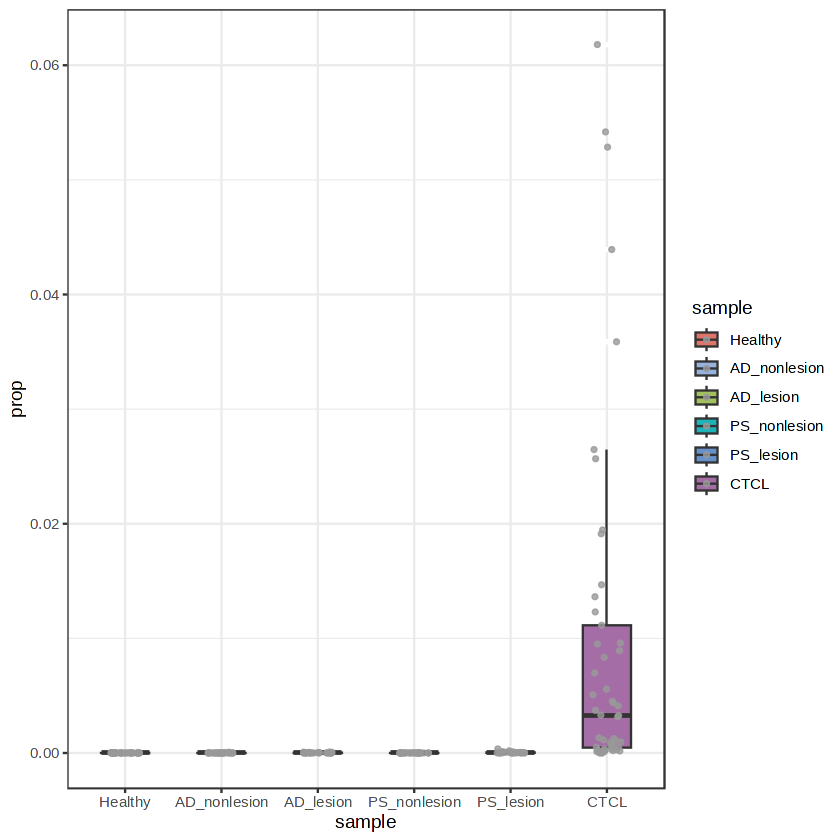

In [55]:
celltype <- "B/plasma"
Est_1_B <- data.frame(prop = Est_1[, celltype], sample = "Healthy")
Est_1_B[grep('^AD.*non-lesional$', rownames(Est_1_B)), 'sample'] <- 'AD_nonlesion'
Est_1_B[grep('^AD.*_lesional$', rownames(Est_1_B)), 'sample'] <- 'AD_lesion'
Est_1_B[grep('^AD.*_chronic_lesion$', rownames(Est_1_B)), 'sample'] <- 'AD_lesion'
Est_1_B[grep('^PSO.*non-lesional$', rownames(Est_1_B)), 'sample'] <- 'PS_nonlesion'
Est_1_B[grep('^PSO.*_lesional$', rownames(Est_1_B)), 'sample'] <- 'PS_lesion'


#celltype <- "B/plasma"
Est_2_B <- data.frame(prop = Est_2[, celltype], sample = "CTCL")

Est <- rbind(Est_1_B, Est_2_B)
Est$sample <- factor(Est$sample, levels = c('Healthy', 'AD_nonlesion', 'AD_lesion',
                                            'PS_nonlesion', 'PS_lesion','CTCL'))

ggplot(data = Est,aes(x = sample, y = prop, fill = sample))+
  geom_boxplot(aes(group=sample), width=0.5, outlier.colour = "white", outlier.size = 0.5)+
  geom_point(position=position_jitter(width = 0.15,height = 0),alpha=0.8,shape=19, color = 'grey60', size = 1)+
  #geom_quasirandom(method = "quasirandom", dodge.width=0.8, size=1.2, shape=20, alpha=1) +
  scale_fill_manual(values = c("#E07469","#97B2DD", "#A1C15F","#1CB4B8", "#6692CC","#A46DA6")) +
theme_bw()

#ggsave('./figures/Decov_F3.pdf', width = 6, height = 5)

In [60]:
c1 <- Est$prop[which(Est$sample == "CTCL")]
c2 <- Est$prop[which(Est$sample == "PS_nonlesion")]

wilcox.test(c1,c2)


	Wilcoxon rank sum exact test

data:  c1 and c2
W = 1278, p-value = 3.766e-15
alternative hypothesis: true location shift is not equal to 0


### Prognostic data

In [14]:
data <- read.table("/home/jovyan/farm/CTCL/deconvolution/PKU_metadata_PFS_OS.xls", header = T)
data <- data[,1:9]

In [16]:
data %>% head()

,Patient,Sex,Age,LCT,Stage,PFS_time,PFS,OS_time,OS
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,B266,F,70,no,IIB,55,1,56,1
2,B355,M,55,LCT,IIB,10,1,10,1
3,B470,M,45,no,IIB,32,0,32,0
4,L107,M,52,LCT,IIB,12,0,12,0
5,L112,M,21,LCT,IIB,4,1,22,1
6,L149,F,15,LCT,IIB,24,1,54,1


In [17]:
E_2 <- readRDS('/lustre/scratch126/cellgen/team205/rl20/CTCL/deconvolution/Deconv_PKU_CTCL_integrated_atlas_sub0.08_DEGs.rds')

Est_2 <- get.fraction(bp=E_2,
            which.theta="final",
            state.or.type="type")

In [18]:
Est_2 <- Est_2[-which(rownames(Est_2)=='B520-2'), c('B/plasma', 'VE2')] ## remove a replecate sample (B520-2 and B520)
dim(Est_2)

[1] 48  2

In [19]:
data_prop <- cbind(data, Est_2)
data_prop <- data_prop[,-ncol(data_prop)]
data_prop %>% head()

,Patient,Sex,Age,LCT,Stage,PFS_time,PFS,OS_time,OS,B/plasma
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>
B266,B266,F,70,no,IIB,55,1,56,1,0.0002125139
B355,B355,M,55,LCT,IIB,10,1,10,1,0.0041122965
B470,B470,M,45,no,IIB,32,0,32,0,0.0003488001
L107,L107,M,52,LCT,IIB,12,0,12,0,0.0005001541
L112,L112,M,21,LCT,IIB,4,1,22,1,0.0541860419
L149,L149,F,15,LCT,IIB,24,1,54,1,0.0358764168


In [20]:
colnames(data_prop) <- c(colnames(data_prop)[1:9],'B_plasma')

In [21]:
colnames(data_prop)

[1] "Patient"  "Sex"      "Age"      "LCT"      "Stage"    "PFS_time"
 [7] "PFS"      "OS_time"  "OS"       "B_plasma"

In [22]:
library(survival)
library(survminer)
library(survMisc)
library(RColorBrewer)

Loading required package: ggpubr


Attaching package: ‘survMisc’


The following object is masked from ‘package:ggplot2’:

    autoplot




In [23]:
cut <- cutp(coxph(Surv(PFS_time, PFS)~Stage+Age+strata(Sex) + B_plasma, data=data_prop))$B_plasma[]
cut %>% head()

B_plasma,U,Q,p
<dbl>,<dbl>,<dbl>,<dbl>
0.0009596550,4.831217,1.129073,0.1561495
0.0004685120,4.783064,1.117819,0.1642364
0.0006903478,4.655408,1.087986,0.1872889
0.0011407570,4.476672,1.046214,0.2237136
0.0009230007,4.458336,1.041929,0.2277355
0.0003488001,4.302756,1.005570,0.2640771


In [24]:
data_prop$tx <- rep(NA, nrow(data_prop))
data_prop$tx[which(data_prop$B_plasma < 0.0009596550)] <- 1
#data$tx[which(data$B_plasma >= 0.027831 & data$B_plasma < 0.094703)] <- 2
data_prop$tx[which(data_prop$B_plasma >= 0.0009596550)] <- 2

In [27]:
#data_prop

[1] 18

[1] 30

Call:
coxph(formula = Surv(PFS_time, as.numeric(PFS)) ~ tx + Stage + 
    Age + strata(Sex), data = data_prop)

  n= 48, number of events= 22 

              coef exp(coef) se(coef)     z Pr(>|z|)  
tx        1.027800  2.794910 0.557120 1.845   0.0651 .
StageIIIA 0.226228  1.253861 1.094749 0.207   0.8363  
StageIIIB 0.641009  1.898396 1.099127 0.583   0.5598  
StageIVA2 1.374665  3.953750 0.610358 2.252   0.0243 *
StageIVB  1.154767  3.173283 1.099753 1.050   0.2937  
Age       0.007979  1.008011 0.015160 0.526   0.5987  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          exp(coef) exp(-coef) lower .95 upper .95
tx            2.795     0.3578    0.9379     8.329
StageIIIA     1.254     0.7975    0.1467    10.718
StageIIIB     1.898     0.5268    0.2202    16.367
StageIVA2     3.954     0.2529    1.1953    13.078
StageIVB      3.173     0.3151    0.3676    27.392
Age           1.008     0.9921    0.9785     1.038

Concordance= 0.688  (se = 0.069 )
Likelihood 

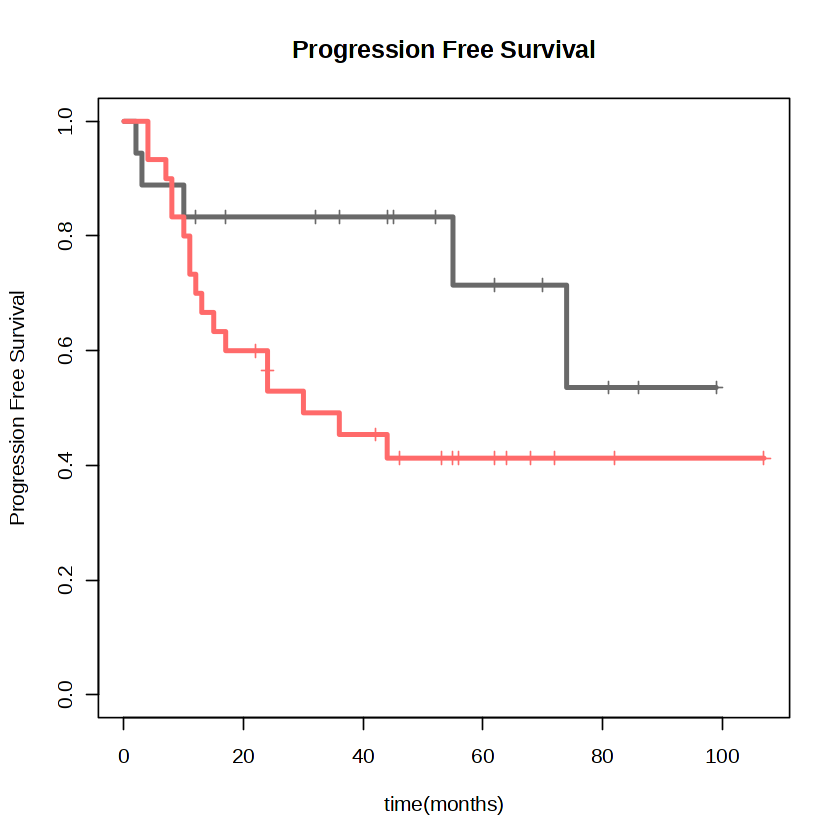

In [28]:
sd <- survfit(Surv(PFS_time, as.numeric(PFS))~tx, data=data_prop, se.fit=T, conf.int=.95,type="kaplan-meier")
#ggsurvplot(sd, data=data, conf.int = TRUE, palette = c("dodgerblue3","red2"))

SD <- coxph(Surv(PFS_time,as.numeric(PFS))~tx+Stage+Age+strata(Sex),data=data_prop)
plot(sd, lty=1, lwd=3, col=c("DimGrey", "IndianRed1"),
     mark.time=T, xlab="time(months)",ylab="Progression Free Survival",main="Progression Free Survival")

sum(data_prop$tx==1)
sum(data_prop$tx==2)

summary(SD)

In [13]:
pdf("./figures/Bcell_prognosis_new.pdf", w=5, h=6)
plot(sd, lty=1, lwd=3, col=c("DimGrey", "IndianRed1"),
     mark.time=T, xlab="time(months)",ylab="Progression Free Survival",main="Progression Free Survival")
dev.off()

png 
  2